In [1]:
import skimage.io
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature
from skimage.feature import corner_harris, corner_subpix, corner_peaks


In [272]:
def visualize_microwave_volume(input_file, dynamic_range=25, label=None):
        """
        Visualize the slices of a microwave image volume in logarithmic scale with the given dynamic_range
        :param string input_file: Path to input file
        :param float dynamic_range: Dynamic range in dB (default: 25)
        """

        img = Model.load_microwave_volume(input_file)

        if label is None:
            label_filename = input_file.replace('.tiff', '.json')
            if os.path.exists(label_filename):
                with open(label_filename, 'r') as file:
                    label = json.loads(file.read())

        fig, axs = plt.subplots(1, 3, figsize=(16, 7))
        for i in range(img.shape[2]):
            volume = 10 * np.log10(img[:, :, i])
            max_val = np.max(volume)
            axs[i].imshow(volume, vmax=max_val, vmin=max_val - dynamic_range)
            axs[i].set_title(f"Slice {i + 1:d}")

            if label is not None:
                x_coords = [coord[0] for coord in label['coordinates']['present']]
                y_coords = [257-coord[1] for coord in label['coordinates']['present']]
                axs[i].scatter(x_coords, y_coords, color='white')

                x_coords = [coord[0] for coord in label['coordinates']['missing']]
                y_coords = [257 - coord[1] for coord in label['coordinates']['missing']]
                axs[i].scatter(x_coords, y_coords, color='red')

        if label is not None:
            fig.canvas.set_window_title(f"Present pills: {len(label['coordinates']['present'])}, "
                                        f"Missing pills: {len(label['coordinates']['missing'])}")

        plt.show()


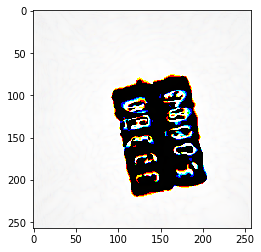

In [273]:
tiff_path = os.path.join('public_data', 'd4143d7aeb4a6b5563cd541b40048b0b.tiff')
#visualize_microwave_volume(tiff_path)

img = skimage.io.imread(tiff_path)
#dynamic_range = 25
rgbArray1 = np.full((257,257,3),0, 'uint8')
#fig, axs = plt.subplots(1, 3, figsize=(16, 7))
for i in range(img.shape[2]):
    rgbArray1[..., i] = 5 * np.log10(img[:, :, i])
    #rgbArray1[..., i] =  img[:, :, i]
#     max_val = np.max(rgbArray1[..., i])
#     axs[i].imshow(volume, vmax=max_val, vmin=max_val - dynamic_range)
#     rgbArray1[..., i] = volume.copy()
#     max_val = np.max(volume)
#     axs[i].imshow(volume, vmax=max_val, vmin=max_val - dynamic_range)
#     axs[i].imshow(volume)
#     axs[i].set_title(f"Slice {i + 1:d}")


plt.imshow(rgbArray1, cmap = 'gray')
# plt.show()
# plt.imshow(rgbArray1[:,:,1])
# plt.show()
# plt.imshow(rgbArray1[:,:,2])
#plt.imshow(rgbArray1)

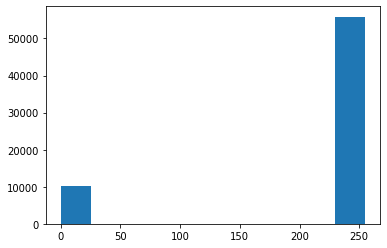

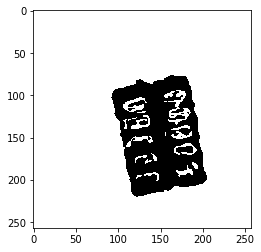

In [274]:
#rgbArray1 = cv2.GaussianBlur(rgbArray1, (1, 1), 0)

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(rgbArray1.reshape(-1, 3))
res = kmeans.labels_.reshape(257, 257)

#res.reshape(257,257)
res = 255 * res

counts, bins, bars = plt.hist(res.flatten())


if counts[0] > counts[-1]:
    a = 255 * np.ones((257,257))
    res = a - res
res = res.astype('u1')

# res = skimage.morphology.binary_dilation(res)
res = res.astype('u1')
plt.figure()
plt.imshow(res, cmap = 'gray')

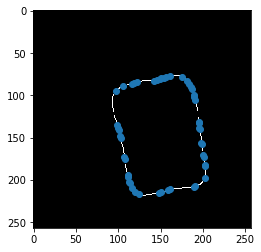

In [275]:
edges1 = feature.canny(res.reshape(257,257), sigma = 10)
coords = corner_peaks(corner_harris(edges1), min_distance=1, threshold_rel=0.1)
coords[:,[0, 1]] = coords[:,[1, 0]]

plt.imshow(edges1.astype('u1'), cmap = 'gray')
plt.scatter(coords[:, 0], coords[:, 1], )
    

In [276]:
rect = cv2.minAreaRect(coords)
box = cv2.boxPoints(rect)
box = np.int0(box)

top_left_x = min(box[:,1])
top_left_y = min(box[:,0])
bot_right_x = max(box[:,1])
bot_right_y = max(box[:,0])

rect = cv2.minAreaRect(coords)
box = cv2.boxPoints(rect) # cv2.boxPoints(rect) for OpenCV 3.x
box = np.int0(box)

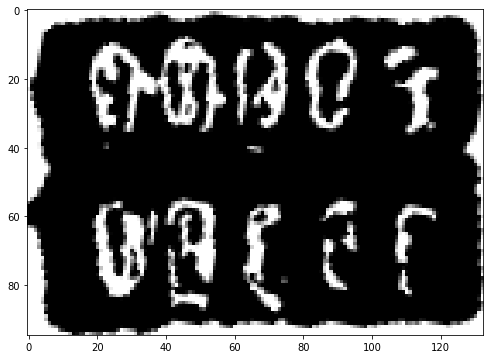

In [277]:
width = int(rect[1][0])
height = int(rect[1][1])

src_pts = box.astype("float32")
# coordinate of the points in box points after the rectangle has been
# straightened
dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")

# the perspective transformation matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)

# directly warp the rotated rectangle to get the straightened rectangle
warped = cv2.warpPerspective(res, M, (width, height))

#cv2.imwrite("crop_img.jpg", warped)

plt.figure(figsize=(18,6))
plt.imshow(warped, cmap= 'gray')

In [224]:
warped.shape

(99, 139)

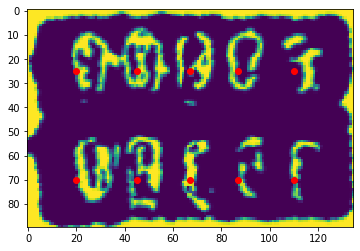

In [279]:
shape = warped.shape

if shape[0] > shape[1]:
    vertical = 1 #detect orientation
else:
    vertical = 0
        
max_shape = max(shape)

if max_shape <141:
    num_pills = 10
    long_dim = 135
    short_dim = 90
    x_points = [25, 70]
    y_points = [20, 45, 67, 87, 110]
    
else:
    num_pills = 15
    long_dim = 150
    short_dim = 90
    y_points= [20, 45, 70, 95, 120]
    x_points = [20, 45, 70]
    
if vertical == 1:
    dim = (short_dim, long_dim)
else:
    dim = (long_dim, short_dim)
    x_points, y_points = y_points, x_points

resized = cv2.resize(warped, dim, interpolation = cv2.INTER_AREA)    
plt.imshow(resized)
points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1,2)
plt.scatter(points[:,0], points[:,1], color = 'r')


# Code below under dev

In [196]:
image = cv2.circle(resized, points[2] , 4, color = 150, thickness= 3)
#cv.circle(img,(447,63), 63, (0,0,255), -1)

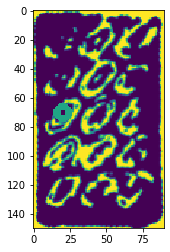

In [197]:
plt.imshow(image)

In [204]:
a1,b1 = points[0]

r= 4
cv2.circle(resized,points[0], r)
result = resized[a1-r:a1+r,b1-r:b1+r]
plt.imshow(result)
# cv2.imshow('image',img)
# cv2.imshow('result',result)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'circle'
> Overload resolution failed:
>  - circle() missing required argument 'color' (pos 4)
>  - circle() missing required argument 'color' (pos 4)


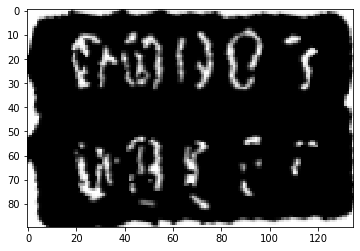

In [270]:
resized = cv2.resize(warped, (135, 90), interpolation = cv2.INTER_AREA)
#test = skimage.morphology.binary_erosion(resized)
#test = skimage.morphology.binary_erosion(test)
test = test.astype('u1') 
#Gaussian = cv2.GaussianBlur(test, (3, 3), 0)
#Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
plt.imshow(resized, cmap= 'gray')

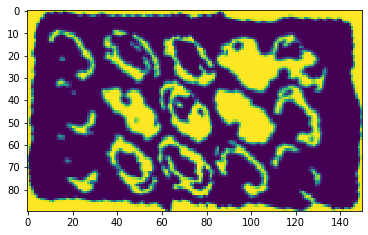

In [22]:
plt.imshow(resized)

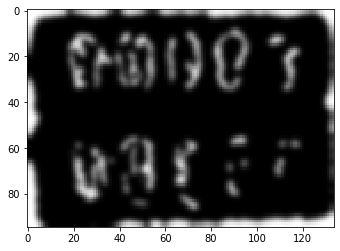

In [271]:
#bilateral = cv2.bilateralFilter(test, 13,75,75)

# bilateral = cv2.bilateralFilter(bilateral, 5,75,75)
# bilateral = cv2.bilateralFilter(bilateral, 5,75,75)

Gaussian = cv2.GaussianBlur(warped, (3, 3), 0)
Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
# #Gaussian = cv2.GaussianBlur(Gaussian, (3, 3), 0)
# Gaussian = cv2.GaussianBlur(Gaussian, (7, 7), 0)
# Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
# # Gaussian = cv2.GaussianBlur(Gaussian, (5, 5), 0)
# #cv2.imshow('Gaussian Blurring', Gaussian)
#test = skimage.morphology.binary_erosion(bilateral)
plt.imshow(Gaussian, cmap= 'gray')
#cv2.waitKey(0)

In [37]:
Gaussian.shape

(90, 150)

In [59]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(Gaussian.reshape(-1, 3))
res = kmeans.labels_.reshape(257, 257)

(133,)

In [55]:
257*257

66049

In [135]:
print(warped.shape)

(91, 150)


(array([782.,  26.,  25.,  21.,  22.,  15.,  21.,  23.,  33., 292.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

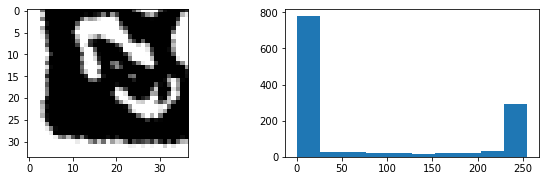

In [144]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(warped[-35:-1,0:37], cmap = 'gray')
plt.subplot(2,2,2)
plt.hist(warped[0:35,0:36].flatten())

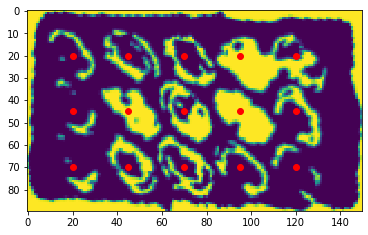

In [141]:
shape = warped.shape

if shape[0] > shape[1]:
    vertical = 1 #detect orientation
else:
    vertical = 0
        
max_shape = max(shape)

if max_shape <139:
    num_pills = 10
    long_dim = 135
    short_dim = 90
    x_points = [25, 70]
    y_points = [20, 45, 67, 87, 110]
    
else:
    num_pills = 15
    long_dim = 150
    short_dim = 90
    y_points= [20, 45, 70, 95, 120]
    x_points = [20, 45, 70]
    
if vertical == 1:
    dim = (short_dim, long_dim)
else:
    dim = (long_dim, short_dim)
    x_points, y_points = y_points, x_points

resized = cv2.resize(warped, dim, interpolation = cv2.INTER_AREA)    
plt.imshow(resized)
points = np.array(np.meshgrid(x_points, y_points)).T.reshape(-1,2)
plt.scatter(points[:,0], points[:,1], color = 'r')